# Lecture 12: Iterative methods

## Syllabus
**Week 1:** Matrices, vectors, matrix/vector norms, scalar products & unitary matrices  
**Week 2:** TAs-week (Strassen, FFT, a bit of SVD)  
**Week 3:** Matrix ranks, singular value decomposition, linear systems, eigenvalues  
**Week 4:** Matrix decompositions: QR, LU, SVD + test + structured matrices start  
**Week 5:** Iterative methods, preconditioners, matrix functions

## Recap of the previous lecture
- Test
- Short intro into sparse matrices and their storage

## Today lecture

Today we will talk about **iterative methods**, where they arise, how we store them, how we operate with them.


- Concept of iterative methods
- Richardson iteration, Chebyshev acceleration
- Jacobi/Gauss-Seidel methods
- Idea of Krylov methods
- Conjugate gradient methods for symmetric positive definite matrices
- Generalized minimal residual methods
- The Zoo of iterative methods: BiCGStab, QMR, IDR, ...
- The idea of preconditioners
- Jacobi/Gauss-Seidel as preconditioner, successive overrelaxation
- Incomplete ILU

## Direct methods

Iterative methods are the main tools for solving large-scale numerical linear algebra problems. 

$$Ax = f,$$

If the matrix $A$ is **dense**, the complexity is $\mathcal{O}(N^3)$, and is feasible only up to $N \sim 10^4 - 10^5$.

If the matrix $A$ is **sparse**, the complexity is $\mathcal{O}(N^{\alpha})$, where $\alpha = \frac{3}{2}$ for 2D problems, and $\alpha = \frac{5}{3}$ for 3D problems (non-optimal).

**But** the matrix-by-vector product is computed in $\mathcal{O}(N)$ operations, **can we use it**?





## Matrix as a black box

We have now an absolutely different view on a matrix: matrix is now a **linear operator**, that acts on a vector,  

and this action can be computed in $\mathcal{O}(N)$ operations.

**This is the only information** we know about the matrix: the <font color='red'> matrix-by-vector product </font>

Can we solve linear systems?

Of course, we can multiply by the colums of the identity matrix, and recover the full matrix, but it is not what we need.

## Richardson iteration
The simplest idea is the **"simple iteration method"** or **Richardson iteration**.  


  $$Ax = f,$$
  $$\tau  (Ax - f) = 0,$$
   $$x - \tau (Ax - f) = x,$$
   $$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
   where $\tau$ is the **iteration parameter**, which can be always chosen such that the method **converges**.

## Convergence of the Richardson method
Let $x_*$ be the solution; introduce an error $e_k = x_{k} - x_*$, then  

$$
     e_{k+1} = (I - \tau A) e_k,
$$

therefore if $\Vert I - \tau A \Vert < 1$ the iteration converges. 

For symmetric positive definite case it is always possible to select $\tau.$

What about the non-symmetric case?

## Optimal parameter choice
The optimal choice for $\tau$ for $A = A^* > 0$ is (prove it!)
$$
  \tau = \frac{2}{\lambda_{\min} + \lambda_{\max}}.
$$

where $\lambda_{\min}$ is the minimal eigenvalue, and $\lambda_{\max}$ is the maximal eigenvalue of the matrix $A$.

So, to find optimal parameter, we need to know the **bounds of the spectra** of the matrix $A$,

and we can compute it by using **power method**.

## Connection to ODEs

The Richardson iteration has a deep connection to the Ordinary Differential Equations (ODE).


Consider a time-dependent problem

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

Then $y(t) \rightarrow A^{-1} f$ as $t \rightarrow \infty$, and the **Euler scheme** reads

$$\frac{(y_{k+1} - y_k)}{\tau} = -A y_k + f.$$

## Convergence speed and condition number

Even with the optimal parameter choice, the error at the next step satisfies

$$e_{k+1} \leq e_k q, \rightarrow e_k \leq c q^k,$$

where 

$$
   q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{c - 1}{c+1},
$$

$$c = \frac{\lambda_{\max}}{\lambda_{\min}} = \mathrm{cond}(A)$$

is the condition number of $A$.

Let us do some demo...

((-0.0058683976325189921+0j), (-3.994131602367478+0j))

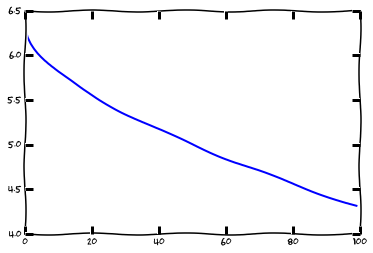

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 40
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=2, which='LR')
ev2, vec = spla.eigs(lp1, k=2, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_all = []
for i in xrange(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    res_all.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.plot(res_all)
lam_max, lam_min

## Condition number of and convergence speed
Thus, for **ill-conditioned** matrices the error of the simple iteration method decays very slowly.

This is another reason why **condition number** is so important:

1. It gives the bound on the error in the solution

2. It gives an estimate of the number of iterations for the iterative methods.

Main questions for the iterative method is how to make the matrix **better conditioned** 

The answer is <font color='red'> use preconditioners </font>

## Better iterative methods

But before preconditioners, we need to use **better iterative methods**. 

There is a whole **zoo** of iterative methods, but we need to know just few of them.

## Attempt 1: Different time steps

Suppose we **change** $\tau$ every step, i.e. 
$$
   x_{k+1} = x_k - \tau_k (A x_k - f).
$$

Then, $$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

where $p(A)$ is a **matrix polynomial** (simplest matrix function)  

$$
   p(A) = (I - \tau_k A) \ldots (I - \tau_0 A),
$$

and $p(0) = 1$.

## Optimal choice of the time steps
The error is written as 

$$e_{k+1} = p(A) e_0, $$
and hence
$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$
where $p(0) = 1$ and $p(A)$ is a **matrix polynomial**. 

To get better **error reduction**, we need to minimize

$$\Vert p(A) \Vert$$ over all possible polynomials.

##  Polynomials least deviating from zeros

Important special case: $A = A^* > 0$.

Then $A = U \Lambda U^*$, 

and 



$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_k |p(\lambda_k)| \leq 
\max_{a \leq \lambda \leq b} p(\lambda).$$

Thus, we need to find a polynomial such that $p(0) = 1$, that has the least possible deviation from $0$ on a given interval $[a, b]$.

##  Polynomials least deviating from zeros (2)

We can do the affine transformation of the interval $[a, b]$ to the interval $[-1, 1]$.

The problem is then reduced to the problem of finding the **polynomial least deviating from zero** on an interval $[-1, 1]$ 

with some normalization constraint $p(c) = 1$.


## Exact solution: Chebyshev polynomials

The exact solution to this problem is given by the famous **Chebyshev polynomials** of the form

$$T_n(x) =  \cos (n \arccos x)$$

## What do you need to know about Chebyshev polynomials

1. This is a polynomial! (we can express $T_n$ from $T_{n-1}$ and $T_{n-2}$).

2. $|T_n(x)| \leq 1$ on $x \in [-1, 1]$.

3. It has $(n+1)$ **alternation points**, were the the maximal absolute value is achieved (this is the sufficient and necessary condition for the **optimality**

4. The **roots** are just  
$n \arccos x_k = \frac{\pi}{2} + \pi k, \rightarrow x_k = \cos \frac{\pi(k + 0.5)}{n}$

We can plot them...

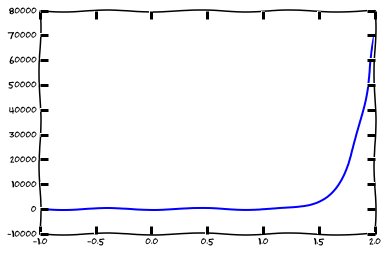

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
%matplotlib inline
x = np.linspace(-1, 2, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
plt.plot(x, p(x))

## Convergence of the Chebyshev-accelerated Richardson iteration

Given the roots of the polynomials $x_k$, the best parameters are determined as 

$$\tau_k = \frac{1}{x_k}.$$

The convergence (we only give the result without the proof) is now given by

$$
   e_{k+1} \leq c q^k, \quad q = \frac{\sqrt{c}-1}{\sqrt{c}+1},
$$

where $c = \mathrm{cond}(A)$.


## Beyond Chebyshev

We have made an important assumption about the spectra: it is contained within an interval over the real line (and we need to know the bounds)

If the spectra is contained within **two intervals**, and we know the bounds, we can also put the optimization problem 

for the **optimal polynomial**.



## Spectra of the matrix contain on multiple segments

For the case of **two segments** the best polynomial is given by **Zolotarev polynomials** (expressed in terms of elliptic functions)

For the case of **more than two segments** the best polynomial can be expressed in terms of **hyperelliptic functions**

<img width=40% src='WAT.jpeg'> </img>

## How can we make it better

The implementation of the Chebyshev acceleration requires the knowledge of the spectra.

It only stores the **previous vector** $x_k$ and computes the new correction vector

$$r_k = A x_k - f.$$

It belongs to the class of **two-term** iterative methods.

It appears that if we **abandon** this and **store more vectors**, then we can go without the spectra estimation (and better convergence in practice)!

## Crucial point

The Chebyshev method produces the approximation of the form

$$x_{k+1} = p(A) f,$$

i.e. it lies in the the **Krylov subspace** of the matrix  which is defined as

$$
   K(A, f) = \mathrm{Span}(f, Af, A^2 f, \ldots, )
$$

The most natural approach then is to find the vector in this **linear subspace** that minimizes 

certain **norm of the error**

## What to minimize in the Krylov subspace

The ideal way is to minimize

$$\Vert x_k - x_* \Vert,$$

over the Krylov subspace $K_n(A, f)$

where $x_*$ is the **true solution**, but we do not know it!

Then we can minimize the **residual**: 

$$\Vert f - Ax \Vert,$$

For the SPD case we can do better!

## Hermitian positive definite case

Consider again $A = A^* > 0$ 

Then we can introduce **A-norm** as 

$$\Vert x \Vert_A =  \sqrt{(Ax, x)}.$$

Let us verify that it is the norm (on the whiteboard).

## Conjugate gradient

The most popular iterative method today (for positive definite matrices) is the **conjugate gradient method**:

It minimizes the **A-norm** of the error over the Krylov subspace

$$x_{k+1} = \arg_{x \in K_n(A, f)} \min \Vert x - x_* \Vert_A$$

And we can compute the minimization without knowing the error!

## Why we can compute A-norm of the error

Given $x$ we can compute the A-norm of the error:

$$\Vert x - x_* \Vert_A^2 =  (A (x - x_*), (x - x_*))$$

## How to get the CG formulas

Consider the one step:

$x_i = x_0 + y_i, \quad y_i = \arg \min \Vert x_0 + y - z \Vert_A, \quad y \in K_n$.  

Using Pythagoreus theorem,

$(x_n, y) = (z, y)_A$ for all $y \in K_n$, $\rightarrow$ $r_n = Ax_n - f \perp K_n$

After some machinery...

## CG-method: formulas

We get the following **three-term** recurrence relations for the CG method:
$$
   \alpha_n = (r_{n-1}, r_{n-1})/(Ap_n, p_n),
$$
$$
   x_n = x_{n-1} + \alpha_n p_n, 
$$
$$
   r_n = r_{n-1} - \alpha_n A p_n,
$$
$$
   \beta_n = (r_n, r_n)/(r_{n-1},r_{n-1}),
$$
$$
    p_{n+1} = r_n + \beta_n p_n
$$


The vectors $p_i$ constitute an A-orthogonal basis in $K_n$.

We store $x$, $p$, $r$ (three vectors).

## CG-method: history
CG-method has a long history:

1. In was proposed in by [Hestenes and Stiefel in 1952](http://nvlpubs.nist.gov/nistpubs/jres/049/jresv49n6p409_A1b.pdf).
2. In exact arithmetics it should give **exact solution** at $n$ iterations
3. In floating-point arithmetics it did not - people thought it is **unstable** compared to Gaussian elimination
4. Only decades later it was realized that it is a wonderful **iterative method**

## CG-method: properties

1. Convergence estimate (same convergence speed as Chebyshev)
  $$
     \Vert e_k \Vert \leq 2 \Big( \frac{\sqrt{c} - 1}{\sqrt{c} + 1} \Big)^k \Vert e_0 \Vert.
  $$
  But it works better in practice!
  
2. CG mystery (why it is much better than Chebyshev) is **clustering of eigenvalues:**

if there are $k$ "outliers", then in $k$ iterations they are "removed" (we can illustrate it on the board)

## Non-symmetric matrices

CG only works for SPD matrices, and (sometimes) for symmetric matrices (although we can divide by zero).

It completely **does not work** for the non-symmetric matrices.

For non-symmetric matrices the two main methods are

1. GMRES (Generalized minimal residual method)
2. BiCGStab (BiConjugate Gradient Stabilized)

## GMRES

GMRES idea is  very simple: **we construct orthogonal basis in the Krylov subspace.** 

Given the basis $q_1, \ldots, q_n$ we compute the residual $r_ n = Ax_n - f$ and orthogonalize it to the basis.

A Python realization is available as ```scipy.sparse.linalg.gmres``` (although quite buggy).

## Disadvantage of GMRES
The main disadvantage of GMRES: we have to store all the vectors, so the memory costs grows with each step.  

We can do <font color='red' size=50.0> restarts </font> (i.e. get a new residual and a new Krylov subspace): we find some approximate solution $x$ 

and now solve the linear system for the correction:

$$A(x + e) = f, \quad Ae = f - Ax,$$

and generate the new **Krylov subspace**.


**BiCGStab method** avoids that using "short recurrences" like in the CG method

## Idea of BiCGStab

Idea of BiCG method is to use the normal equations:

$$A^* A x = A^* f,$$

and apply the CG method to it.

The condition number has squared, thus we need **stabilization**.

The stabilization idea proposed by Van der Vorst et al. gives the most practically used iterative method for non-symmetric systems.

Let us do some demo

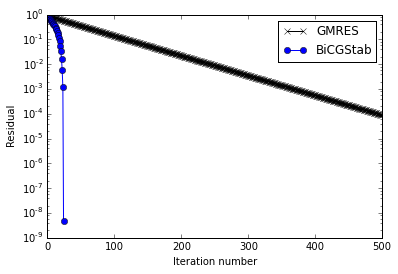

In [23]:
#### import numpy as np
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
n = 50
ex = np.ones(n);
lp1 = -sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ee = sp.sparse.eye(n)

#lp2 = sp.kron(lp1, ee) + sp.kron(ee, lp1)
#rhs = np.ones(n * n)
res_all = []
res_all_bicg = []
def my_print(r):
    res_all.append(r)

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg.append(np.linalg.norm(lp1.dot(x) - rhs))
#res_all_bicg = np.array(res_all_bicg)
sol = scipy.sparse.linalg.gmres(lp1, rhs, restart=10, callback=my_print)
plt.semilogy(res_all, marker='x',color='k', label='GMRES')
sol2 = scipy.sparse.linalg.bicgstab(lp1, rhs, x0=np.zeros(n), callback=my_print2)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]

plt.xlabel('Iteration number')
plt.ylabel('Residual')
plt.semilogy(res_all_bicg, label='BiCGStab', marker='o')
plt.legend(loc='best')

## Battling the condition number

The condition number problem is **un-avoidable** if only the matrix-by-vector product is used.

Thus we need an **army of preconditioners** to solve it.

There are several **general purpose** preconditioners that we can use (short list today, more details tomorrow),  

but often for a particular problem a special design is needed.

## Preconditioner: general concept

The general concept of the preconditioner is simple:

Given a linear system 

$$A x = f,$$

we want to find the matrix $P$ such that 

1. We can easily solve $Py = g$ for any $g$
2. Condition number of $AP^{-1}$ (right preconditioner) or $P^{-1}A$ (right preconditioner) is better than for $A$

Then we solve for (right preconditioner)

$$ AP^{-1} y = f \quad \Rightarrow \quad P x = y$$ 

or  (left preconditioner)

$$ P^{-1} A x = P^{-1}f,$$ 

The best choice of course is $P = A,$ but this does not make life easier.


## Other iterative methods as preconditioners
There are other iterative methods that we have not mentioned. 

1. Jacobi method
2. Gauss-Seidel method
3. SSOR (Successive over-relaxation)

## Jacobi method

Jacobi method is when you express the diagonal element:

$$a_{ii} x_i = -\sum_{i \ne j} a_{ij} x_j + f_i$$

and use this to iteratively update $x_i$:
$$ x_i^{(k+1)} = -\frac{1}{a_{ii}}\left( \sum_{i \ne j} a_{ij} x_j^{(k)} + f_i \right),$$
or in the matrix form
$$
x^{(k+1)} = D^{-1}\left((D-A)x^{(k)} + f\right) 
$$
where $D = \mathrm{diag}(A)$ and finally
$$
x^{(k+1)} = x^{(k)} - D^{-1}(Ax^{(k)} - f).
$$

So, Jacobi method is nothing, but simple Richardson iteration with $\tau=1$ and left preconditioner $P = D$ - diagonal of a matrix. Therefore we will refer to $P = \mathrm{diag}(A)$ as **Jacobi preconditioner**. Note that it can be used for any other method like Chebyshev or Krylov-type methods.

## Gauss-Seidel (as preconditioner)
Another well-known method is **Gauss-Seidel method**. Given $A = A^{*} > 0$ we have  

$$A = L + D + L^{*},$$

where $D$ is the diagonal of $A$, $L$ is lower-triangular part. 
Similarly to the Jacobi method it finally looks like

$$
x^{(k+1)} = x^{(k)} - (L + D)^{-1}(Ax^{(k)} - f).
$$
and we refer to the preconditioner $P = L+D$ as Gauss-Seidel preconditioner.

**Good news: ** $\rho(I - (L+D)^{-1} A) < 1, $

where $\rho$ is the spectral radius.

## Successive overrelaxation (as preconditioner)

We can even introduce a parameter into the preconditioner, giving a **SSOR** method:

$$(D + \omega L) x = \omega b - (\omega U + (\omega-1) D) x,$$

$$P = (D+\omega L)^{-1} (\omega U + (\omega-1) D).$$

Optimal selection of $\omega$ is **not trivial**.


## Others (but very important, see it tomorrow)

- Incomplete LU for sparse matrices (tomorrow)
- Algebraic multigrid
- Sparse approximate inverse 
- Domain decomposition

## Take home message
- Iterative methods are the core
- Krylov subspaces are the core
- Condition number is the problem
- Conjugate gradient is the best for SPD
- GMRES/BiCGStab are the best for non-symmetric
- Preconditioners are crucial (and often do not work)

## Next lecture
- More on preconditioners for sparse matrices

# Questions?

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()